# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.insert(0, '../../')

In [3]:
from src.serve import *

Failed to load FluidSynth. Must install if you want to convert to wav files.


In [4]:
np.set_printoptions(edgeitems=10, threshold=40, linewidth=200)

In [6]:
data_dir = 'data/midi/v10/'
source_dir = 'midi_encode'

file_path = Path('../../')
path = file_path/data_dir/source_dir
out_path = file_path/'data/generated/'

In [11]:
# config = v10_small_config(vocab_path=path/'tmp/all'); config
config = v10_single_config(vocab_path=path/'tmp/all'); config
config['mem_len'] = 1024
config['bptt'] = 512

{'ctx_len': 150,
 'n_layers': 12,
 'n_heads': 12,
 'd_model': 256,
 'd_head': 64,
 'd_inner': 2100,
 'resid_p': 0.1,
 'attn_p': 0.1,
 'ff_p': 0.1,
 'embed_p': 0.1,
 'output_p': 0.1,
 'bias': False,
 'scale': True,
 'act': <Activation.GeLU: 3>,
 'double_drop': True,
 'tie_weights': True,
 'out_bias': True,
 'init': <function fastai.text.models.transformer.init_transformer(m)>,
 'mem_len': 512,
 'mask': True,
 'emb_map': [(0, 262, 256)],
 'idx_map': {0: (0, 262, 256)},
 'loss_weights': [1, 1],
 'pad_idx': 0,
 'bos_idx': 2,
 'sep_idx': 1,
 'enc_offset': 3,
 'transpose_range': (0, 12),
 'mask_type': <MaskType.RandomWindow: 3>,
 'bs': 16,
 'bptt': 256,
 'single_stream': True}

In [12]:
data = load_data(path=path, cache_name='tmp/hook', **config)

In [13]:
saved_models = get_files(path/'models/single', recurse=True); saved_models

[PosixPath('../../data/midi/v10/midi_encode/models/single/small/hook_c/1_ep24.pth'),
 PosixPath('../../data/midi/v10/midi_encode/models/single/hook_c/1_ep48_best.pth')]

In [14]:
load_path = saved_models[-1]

In [15]:
learn = load_learner(data, config, load_path)

Sep_idx: 1


In [16]:
# htlist = get_htlist(path, source_dir)

### From batch

In [17]:
xb,yb = learn.data.one_batch(cpu=False)

### From song

In [18]:

csv_path = path/f'{source_dir}.csv'
csv = pd.read_csv(csv_path)
df = csv.loc[csv['numpy'].notna()];

/Users/andrewshaw/miniconda3/envs/midi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (4,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [19]:
keywords = 'la bamba'.replace(' ', '|')
title_filter = df['title'].str.contains('flows')==True
artist_filter = df['artist'].str.contains('')==True
results = df[title_filter & artist_filter]; results.head()
results = results[results.source == 'musescore']; results.head()

,ht_bpm,md5,numpy,ht_time_signature,midi_title,source,artist,ht_offset,section,song_url,mxl,ht_key,parts,title,genres,midi,ht_mode
56458,NaN,6b9ca5372ccc88e8091d40f295d57f27,midi_encode/musescore/data/4272456.npy,NaN,NaN,musescore,ArnavAmit,NaN,NaN,NaN,midi_sources/musescore/data/4272456.mxl,NaN,NaN,River flows in you,"classical,pop,inferred",NaN,NaN
59842,NaN,c6e9d95919225f8d643c4e9332fcd1c4,midi_encode/musescore/data/4743256.npy,NaN,NaN,musescore,Christian Pich von Lipinski,NaN,NaN,NaN,midi_sources/musescore/data/4743256.mxl,NaN,NaN,River flows in you (easy arrangement),"classical,pop,inferred",NaN,NaN
60321,NaN,d923b7a1b02c90f22b07817a268d8860,midi_encode/musescore/data/4965414.npy,NaN,NaN,musescore,Rea H,NaN,NaN,NaN,midi_sources/musescore/data/4965414.mxl,NaN,NaN,River flows in you - piano,"classical,pop,inferred",NaN,NaN


In [20]:
file = file_path/data_dir/results.numpy.values[0]; file

PosixPath('../../data/midi/v10/midi_encode/musescore/data/4272456.npy')

In [21]:
# file = np.random.choice(files)

In [22]:
#good_one = Path('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/c/cool-and-new-web-comic/tick---tock/chorus.npy')
# file = Path('../../data/midi/v9/midi_encode/np/shortdur/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.npy')
# third_eye = Path('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/t/third-eye-blind/semi-charmed-life/chorus.npy')

In [23]:
seed_len = 140
song_np = np.load(file)
seed_np = np.load(file)[:seed_len]
xb = torch.tensor(to_single_stream(seed_np))[None]
if torch.cuda.is_available(): xb = xb.cuda()

### Predict

In [24]:
# res1 = torch.randint(0, 1000, (10,10)).float(); res1

# res2 = res1.pow(1 / 10)
# res2 = res2 / res2.sum()
# (res2*1000).round()/1000

# resd5 = res1.pow(1 / .5)
# resd5_prob = resd5 / resd5.sum()
# (resd5_prob*1000).round()/1000

In [25]:
# out, seed = learn.predict(xb, n_words=340, temperature=1, min_p=0.01)

In [26]:
# Higher temperature = More randomness (1.5)
# Lower temperature = Less random (.5)

## Learn predict

In [27]:
out_s, seed_s = learn.predict(xb, n_words=800, temperatures=(1.0,.5), min_ps=(1/128,0.0))
out = to_double_stream(out_s)
seed = to_double_stream(seed_s)

### Actual prediction

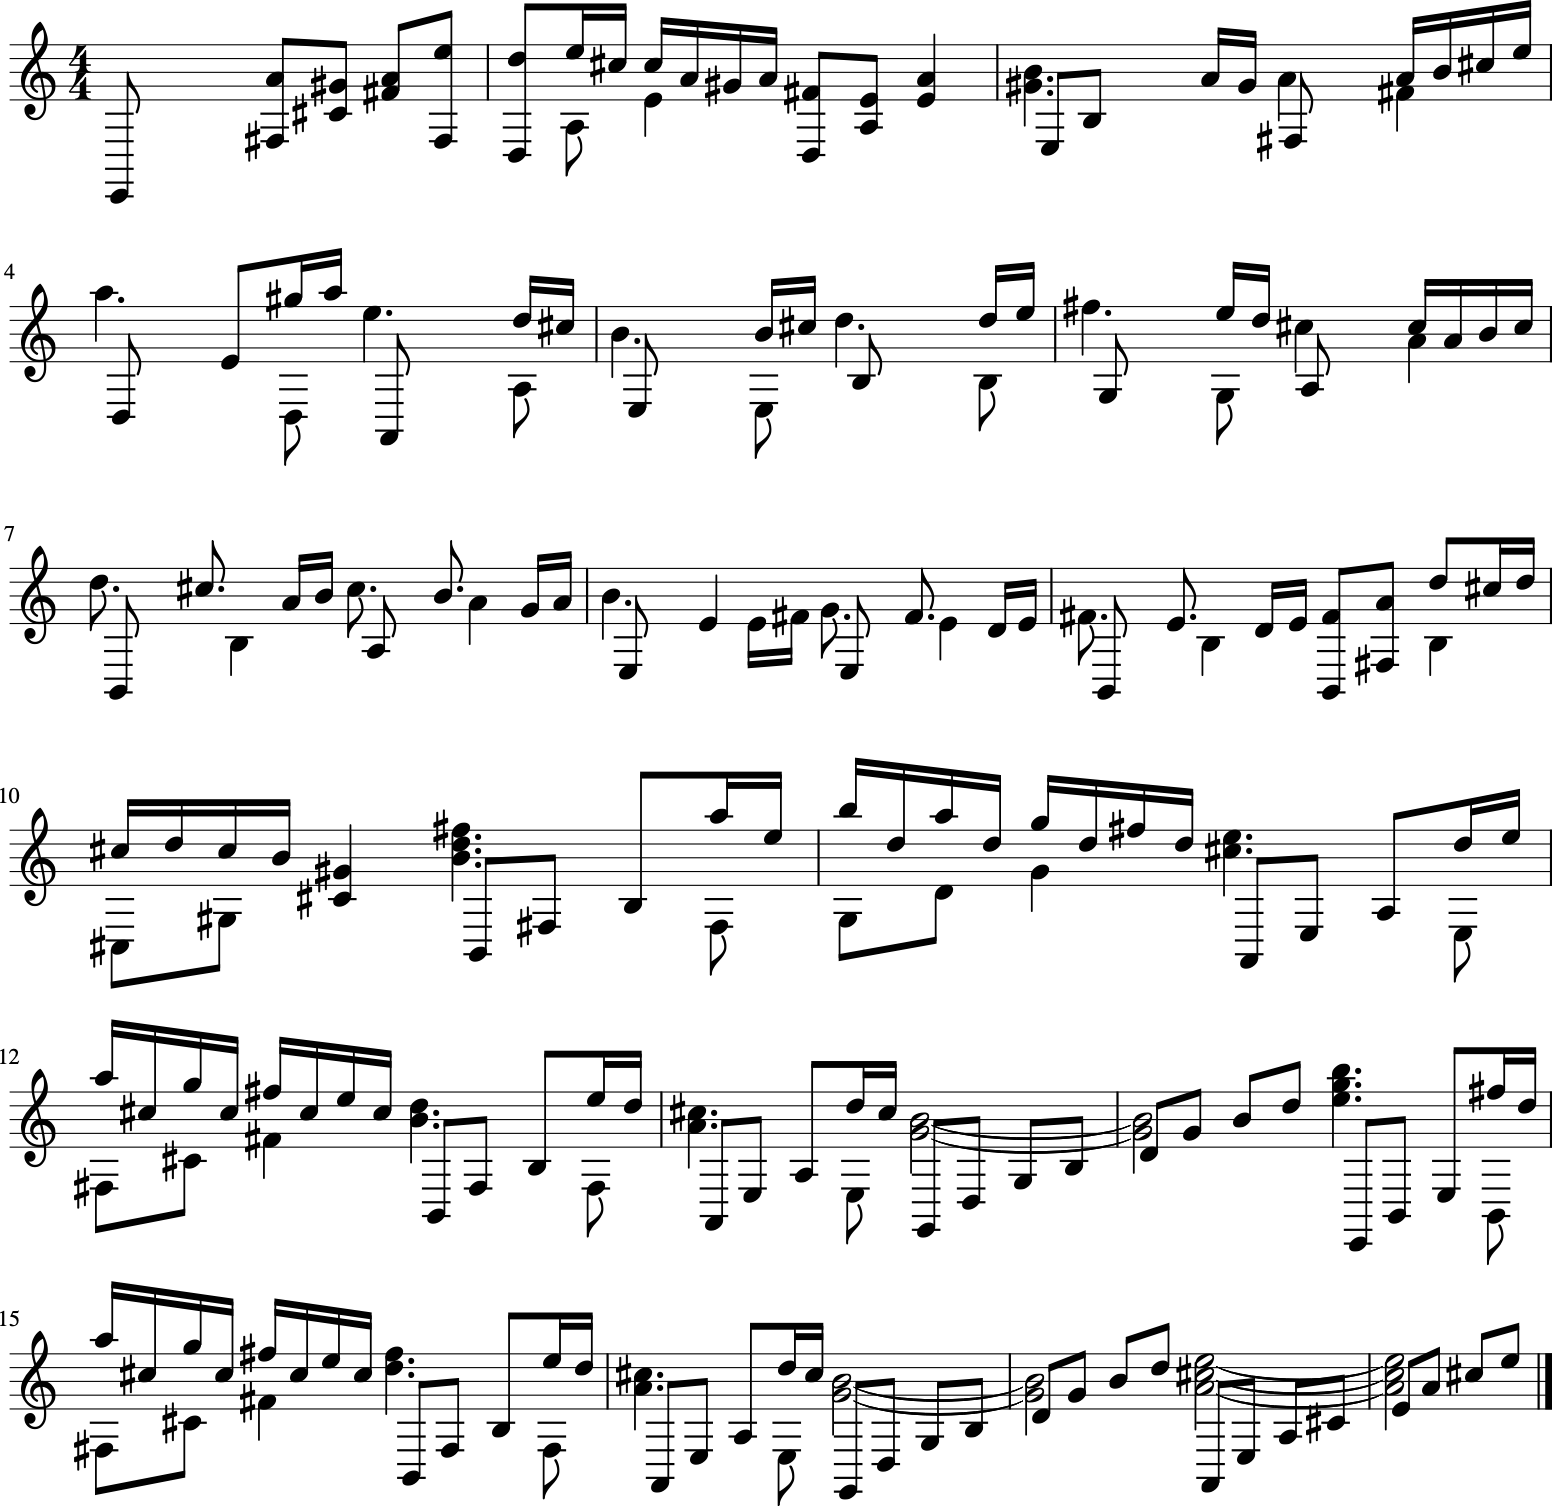

In [28]:
stream = npenc2stream(out)
stream.show()

In [29]:
stream.show('midi')

## Seed

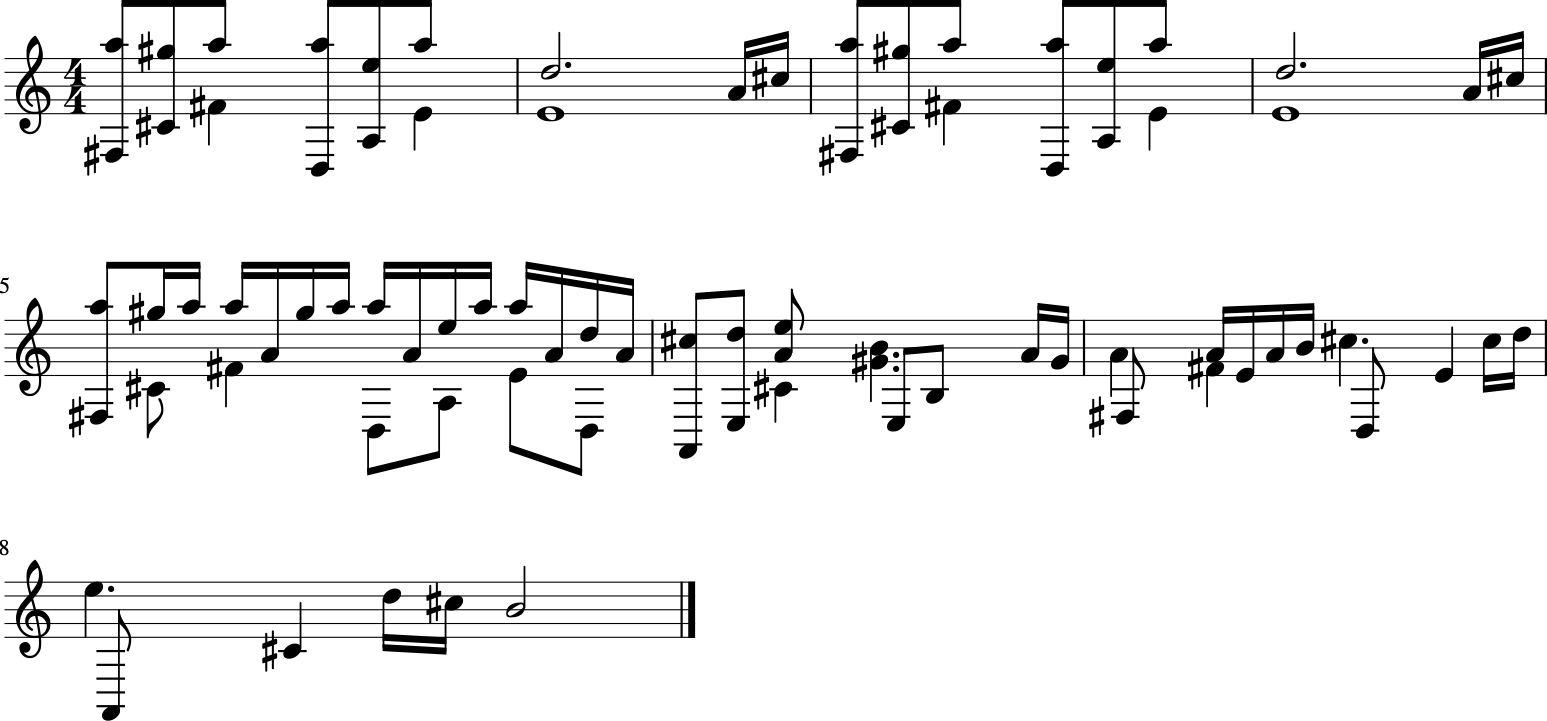

In [30]:
seed_stream = npenc2stream(seed)
seed_stream.show()

In [31]:
seed_stream.show('midi')

## Alltogether now

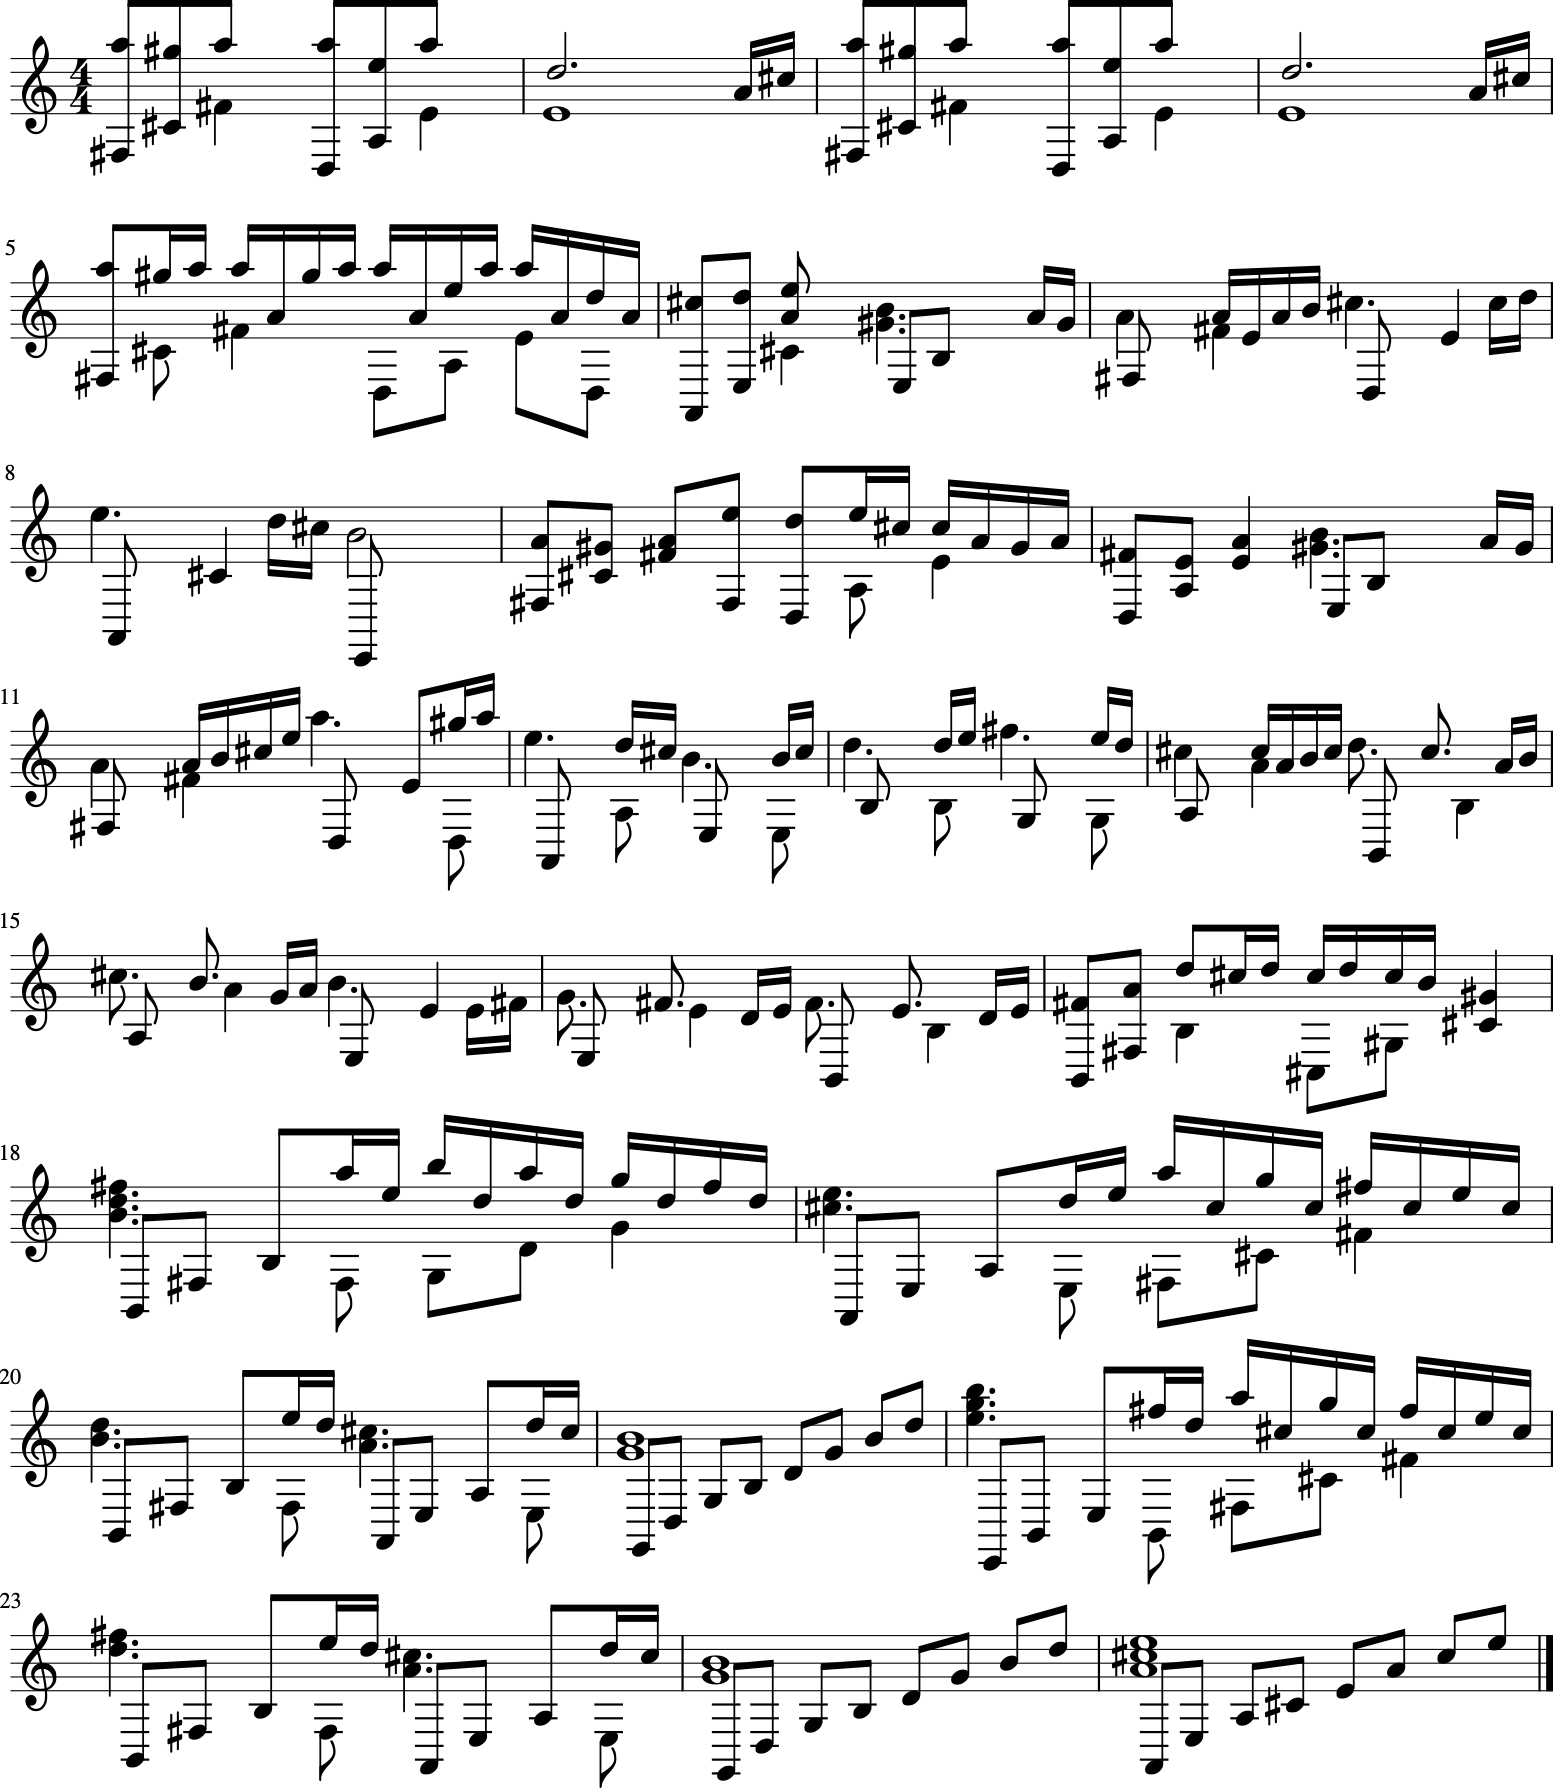

In [32]:
full_output = np.concatenate((seed,out), axis=0)
full_stream = npenc2stream(full_output)
full_stream.show()

In [33]:
full_stream.show('midi')

### Original

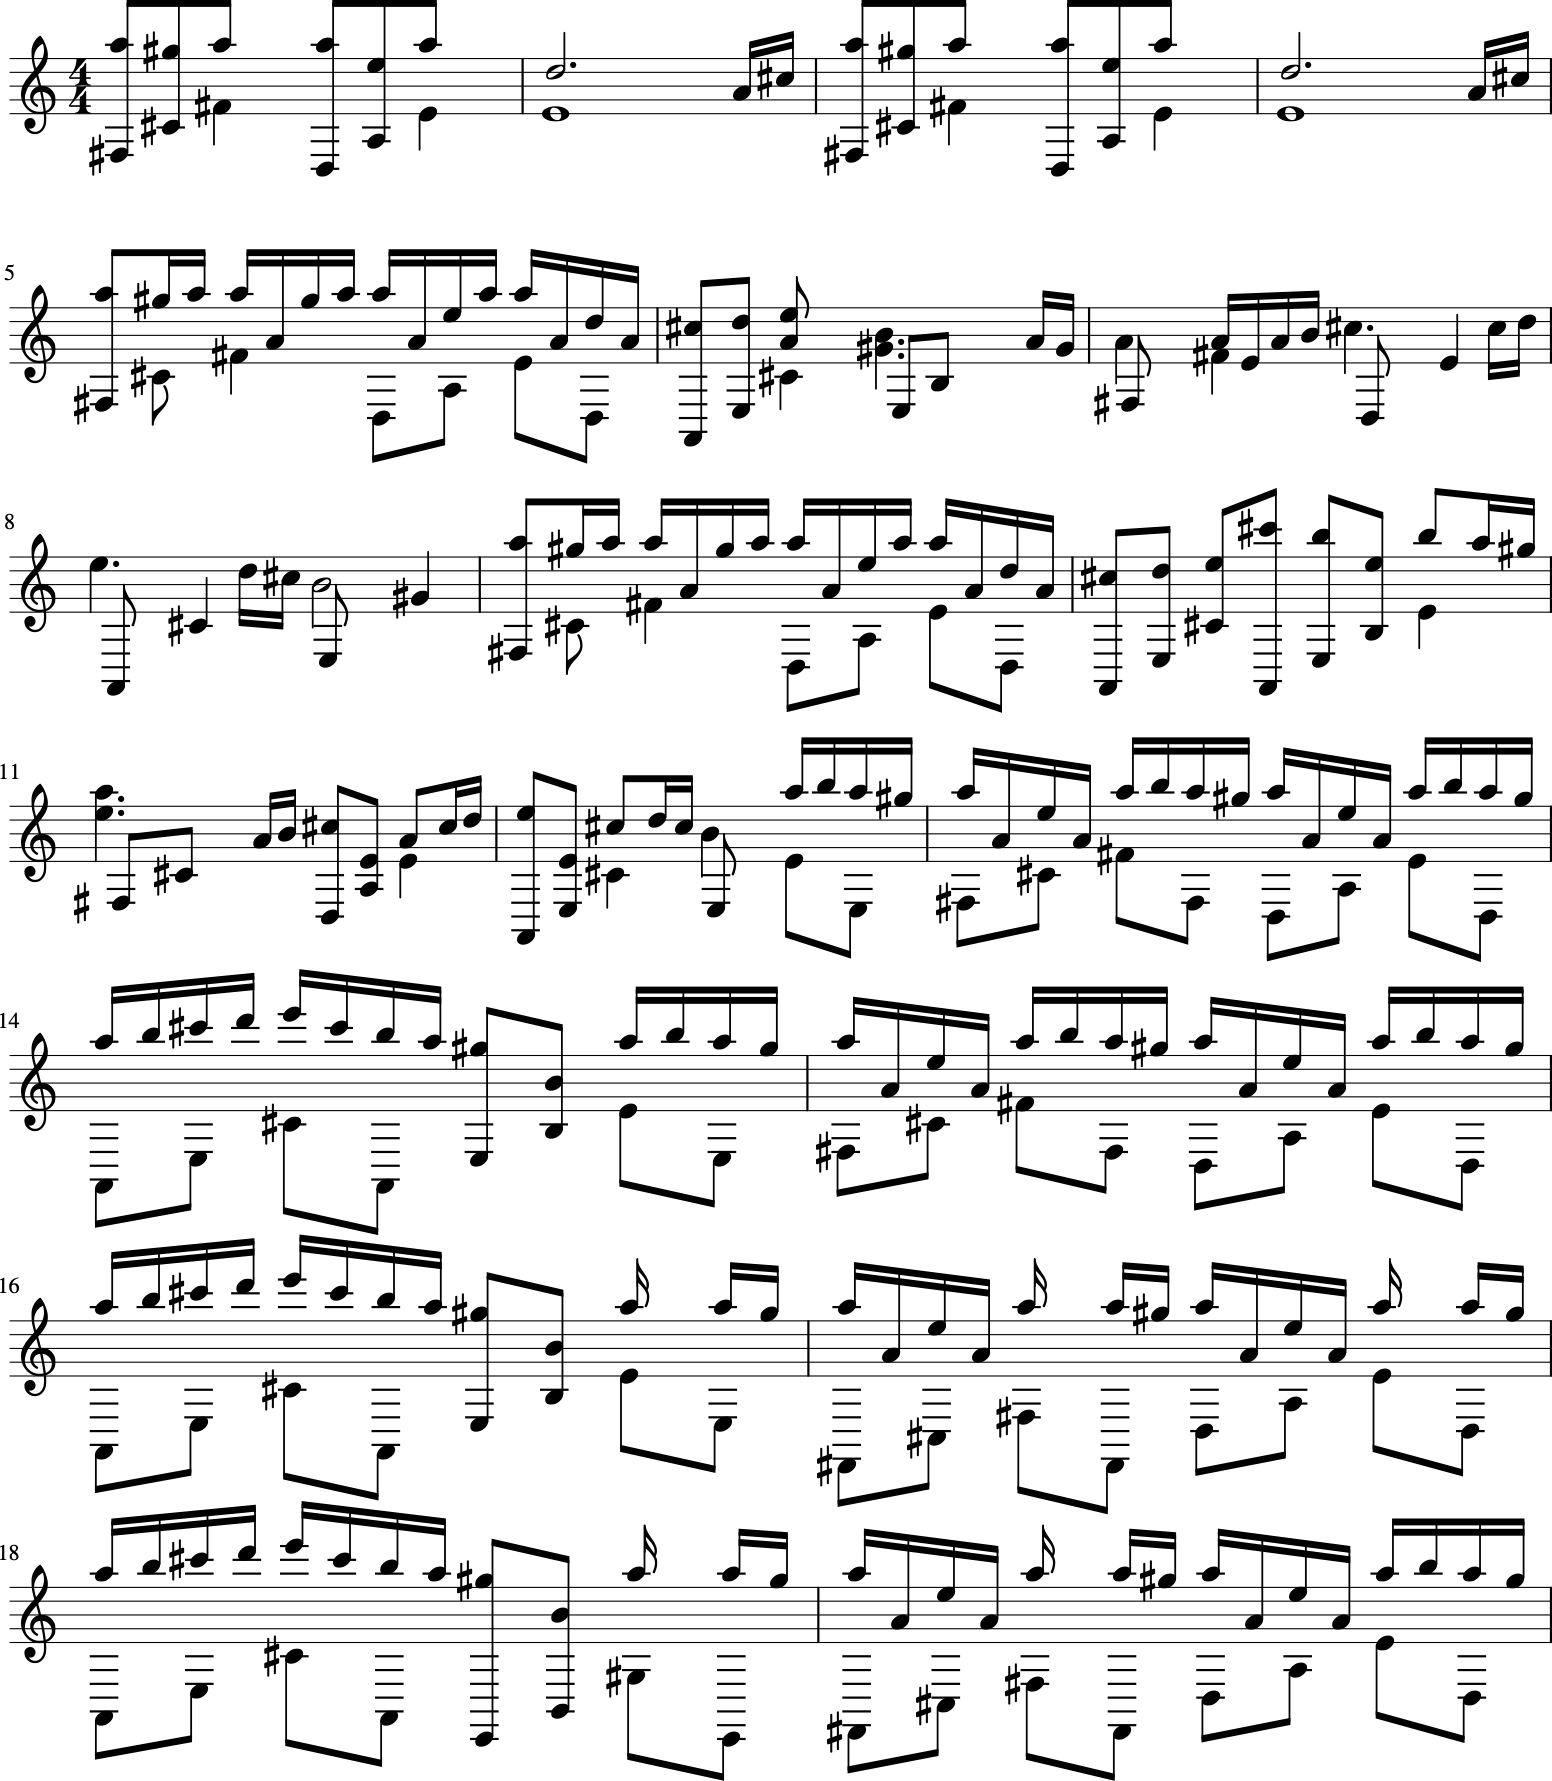

In [34]:
original_stream = npenc2stream(song_np)
original_stream.show()

In [35]:
original_stream.show('midi')